# Background

- First pass at rotation analysis in 07-07-22 notebook.
- Wanting to start with a fresh notebook, and capture the best pieces from the previous notebook.
- I am anticipating that a good model for the orientation will need to include the Planar Hall Effect (PHE)
    - I ended the previous notebook by qualitatively comparing PHE to residuals from $\cos\theta$ fit. It looked reasonably similar.
- PHE may should help define/constrain the $\phi$ orientation.
    - At some level, this will depend on which Hall element, and will not be exactly the same for each Hall probe.
- Perhaps it is better to constrain $\phi$ with a particular Hall probe calibrated values that we call "good".
- Ultimately this must be tied back to the metrology...

# Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
# from datetime import datetime
# from datetime import timedelta
# from pandas.api.types import is_numeric_dtype
# from scipy.interpolate import interp1d
# from scipy.spatial.transform import Rotation
import lmfit as lm
# from copy import deepcopy
#from dateutil import parser
# from plotly import graph_objects as go
# from plotly.offline import plot
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
# from plotting import config_plots, datetime_plt, get_label
from plotting import config_plots, get_label
from load_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d, scatter2d, histo, spherical_scatter3d
from mu2e.mu2eplots import mu2e_plot3d
# V vs. B, T (2021 results)
from V_vs_B_T import V_forward, inv_B_v2, invert_row, calc_B_column

config_plots()
# plt.rcParams.update({"text.usetex": True})

# Functions

## Processing

In [51]:
def get_probe_IDs(df):
    probes = [c[:-6] for c in df.columns if "Raw_X" in c]
    return sorted(probes)

def Hall_probe_basic_calcs(df, probes):
    # magnitudes and angles
    for p in probes:
        for t in ['Raw', 'Cal']:
            df[f'{p}_{t}_Bmag'] = (df[f'{p}_{t}_X']**2 + df[f'{p}_{t}_Y']**2 + df[f'{p}_{t}_Z']**2)**(1/2)
            df[f'{p}_{t}_Theta'] = np.arccos(df[f'{p}_{t}_Z']/df[f'{p}_{t}_Bmag'])
            df[f'{p}_{t}_Phi'] = np.arctan2(df[f'{p}_{t}_Y'],df[f'{p}_{t}_X'])
    # again using theta redefining Cal components
    for p in probes:
        for t in ['Cal']:
            df[f'{p}_{t}_Theta2'] = np.arccos(df[f'{p}_{t}_X']/df[f'{p}_{t}_Bmag'])
            df[f'{p}_{t}_Phi2'] = np.arctan2(df[f'{p}_{t}_Z'],df[f'{p}_{t}_Y'])
    # magnet slow controls
    df['Magnet Resistance [Ohm]'] = df['Magnet Voltage [V]'] / df['Magnet Current [A]']
    df['Coil Resistance [Ohm]'] = 2*df['Magnet Resistance [Ohm]']
    df['Magnet Power [W]'] = df['Magnet Voltage [V]'] * df['Magnet Current [A]']
    # center smaract measured values around zero
    a1 = df.loc[:, 'SmarAct_Meas_Angle_1'].values
    a2 = df.loc[:, 'SmarAct_Meas_Angle_2'].values
    a1[a1 > 180.] = a1[a1 > 180.] - 360.
    a2[a2 > 180.] = a2[a2 > 180.] - 360.
    df.loc[:, 'SmarAct_Meas_Angle_1_Centered'] = a1
    df.loc[:, 'SmarAct_Meas_Angle_2_Centered'] = a2
    ### INTERPOLATE NMR VALUES TO SCAN TIMES
    #### STOPPED HERE 2022-11-29 17:41:36 
    return df

def match_temp_scan_dfs(df_temp, df):
    # assumes scan df is a subset of temp df.
    t0 = df.index[0]
    tf = df.index[-1]
    df_t = df_temp.query(f'"{t0}" <= Datetime <= "{tf}"').copy()
    return df_t

# File Info

In [4]:
ddir = '/home/ckampa/Dropbox/LogFiles/temp_rotate_07-06-22/'

In [5]:
# 7-6-22 14:05, probe ##, rotating in magnet, coarse scan
# PGC @ 15 deg C
# 2 deg steps -10 -- +6 angle 0 (theta)
# 45 deg steps full 360 deg, centered on -16 deg angle 1 (phi)
######
# plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2022-07-06_14:05/'
# scanfile = ddir+'2022-07-06 140532.txt'
# slowfile = ddir+'2022-07-06 133626slow.txt'

In [6]:
# 7-6-22 14:05, probe ##, rotating in magnet, fine scan
# PGC @ 15 deg C
# 1 deg steps -10 -- +6 angle 0 (theta)
# 2 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
# plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2022-07-06_16:02/'
# scanfile = ddir+'2022-07-06 160256.txt'
# slowfile = ddir+'2022-07-06 133626slow.txt'

In [7]:
# 7-7-22 12:04, probe ##, rotating in magnet, finer scan
# PGC @ 15 deg C
# 0.25 deg steps -10 -- +6 angle 0 (theta)
# 1 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2022-07-07_12:04/'
scanfile = ddir+'2022-07-07 120406.txt'
slowfile = ddir+'2022-07-06 133626slow.txt'

In [8]:
# 7-11-22 16:47, probe ##, rotating in magnet, fine scan
# PGC @ 20 deg C, to be in range with V vs. B, T measurements (2021)
# 1 deg steps -10 -- +6 angle 0 (theta)
# 2 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
# plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2022-07-11_16:47/'
# scanfile = ddir+'2022-07-11 164742.txt'
# slowfile = ddir+'2022-07-06 133626slow.txt'

# Load and Process Data

In [52]:
# temperature
df_temp = load_data(slowfile)
# scan data
df = load_data(scanfile).iloc[1:]

In [53]:
probes = get_probe_IDs(df)
probe = probes[0]
probes

['2F0000000D5EC73A']

In [54]:
df = Hall_probe_basic_calcs(df, probes)

In [55]:
df_t = match_temp_scan_dfs(df_temp, df)

In [56]:
df

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],2F0000000D5EC73A_Raw_X,2F0000000D5EC73A_Raw_Y,2F0000000D5EC73A_Raw_Z,2F0000000D5EC73A_Raw_T,2F0000000D5EC73A_Cal_X,...,2F0000000D5EC73A_Cal_Bmag,2F0000000D5EC73A_Cal_Theta,2F0000000D5EC73A_Cal_Phi,2F0000000D5EC73A_Cal_Theta2,2F0000000D5EC73A_Cal_Phi2,Magnet Resistance [Ohm],Coil Resistance [Ohm],Magnet Power [W],SmarAct_Meas_Angle_1_Centered,SmarAct_Meas_Angle_2_Centered
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-07-07 12:04:50,7/7/2022 12:04:50 PM,179.683880,21.077967,0.0,0.0,-84990.0,-387985.0,-2762867.0,16130.0,0.988046,...,0.999894,1.517354,-0.144602,0.154097,2.786132,0.117306,0.234612,3787.370833,-9.883309,179.999978
2022-07-07 12:04:58,7/7/2022 12:04:58 PM,179.683880,21.078583,0.0,0.0,-91381.0,-385666.0,-2762948.0,16136.0,0.988047,...,0.999899,1.515024,-0.143756,0.154126,2.769990,0.117309,0.234619,3787.481638,-9.883324,-178.999982
2022-07-07 12:05:06,7/7/2022 12:05:06 PM,179.683937,21.079183,0.0,0.0,-97593.0,-383344.0,-2762920.0,16145.0,0.988012,...,0.999871,1.512760,-0.142914,0.154174,2.754260,0.117313,0.234625,3787.590643,-9.883299,-177.999979
2022-07-07 12:05:13,7/7/2022 12:05:13 PM,179.683880,21.079750,0.0,0.0,-103787.0,-380855.0,-2762979.0,16151.0,0.988005,...,0.999868,1.510504,-0.142008,0.154198,2.738438,0.117316,0.234632,3787.691269,-9.883286,-176.999989
2022-07-07 12:05:21,7/7/2022 12:05:21 PM,179.683937,21.080150,0.0,0.0,-110017.0,-378333.0,-2763098.0,16156.0,0.988018,...,0.999890,1.508237,-0.141087,0.154250,2.722514,0.117318,0.234636,3787.764338,-9.883292,-175.999983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09 18:48:07,7/9/2022 6:48:07 PM,179.684220,21.066800,0.0,0.0,172498.0,320694.0,-2783636.0,16081.0,0.992154,...,0.999811,1.621862,0.112876,0.123845,-0.425981,0.117243,0.234487,3785.371526,5.999997,176.000007
2022-07-09 18:48:14,7/9/2022 6:48:14 PM,179.684277,21.066850,0.0,0.0,178483.0,317871.0,-2783618.0,16086.0,0.992179,...,0.999833,1.624033,0.111842,0.123818,-0.445442,0.117244,0.234487,3785.381704,6.000026,177.000007
2022-07-09 18:48:22,7/9/2022 6:48:22 PM,179.684220,21.066933,0.0,0.0,184386.0,314935.0,-2783514.0,16074.0,0.992168,...,0.999819,1.626174,0.110770,0.123791,-0.464821,0.117244,0.234488,3785.395484,6.000023,177.999997


In [57]:
df_t

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1,Coil 2,LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke (near pole),...,Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),NaN (NWC-S),Supply PS (FNAL),NMR [T],NMR [FFT],seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-07-07 12:07:03,7/7/2022 12:07:03 PM,179.683823,21.076333,26.202082,24.673046,6.521139,9.986544,7.233150,10.426664,15.932531,...,10.479848,30.423721,6.384603,18.297808,32.620407,0.999832,0.0,81036.0,22.510000,0.937917
2022-07-07 12:12:03,7/7/2022 12:12:03 PM,179.683880,21.078400,26.198442,24.709051,6.384720,10.009138,7.185710,10.339764,15.936610,...,10.783925,31.274315,6.040265,18.325209,32.621765,0.999831,0.0,81336.0,22.593333,0.941389
2022-07-07 12:17:03,7/7/2022 12:17:03 PM,179.683880,21.080250,26.222877,24.711410,7.005603,10.591073,7.784220,10.900702,15.935767,...,11.487394,31.836945,6.106501,18.377869,32.606373,0.999831,0.0,81636.0,22.676667,0.944861
2022-07-07 12:22:03,7/7/2022 12:22:03 PM,179.683880,21.080467,26.185261,24.682249,7.945996,11.255135,8.563878,11.628212,15.933943,...,12.074346,32.515247,7.059671,18.371607,32.610413,0.999832,0.0,81936.0,22.760000,0.948333
2022-07-07 12:27:03,7/7/2022 12:27:03 PM,179.683880,21.079083,26.167950,24.662447,8.673299,11.682805,9.128124,12.160546,15.939552,...,12.182293,32.883438,8.089366,18.290703,32.616386,0.999831,0.0,82236.0,22.843333,0.951806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09 18:27:04,7/9/2022 6:27:04 PM,179.684220,21.068217,26.110544,24.564087,8.175622,11.312326,9.525085,11.732266,15.929981,...,11.476092,28.512703,8.177090,18.306189,32.325878,0.999831,0.0,276637.0,76.843611,3.201817
2022-07-09 18:32:04,7/9/2022 6:32:04 PM,179.684220,21.067517,26.124727,24.552584,7.845795,11.049525,9.351840,11.482889,15.927117,...,11.230319,29.220245,7.826111,18.290075,32.227726,0.999832,0.0,276937.0,76.926944,3.205289
2022-07-09 18:37:04,7/9/2022 6:37:04 PM,179.684277,21.067100,26.133797,24.563242,7.396679,10.724196,9.060145,11.161573,15.930570,...,10.930471,29.437111,7.390028,18.352137,32.327789,0.999833,0.0,277237.0,77.010278,3.208762


# Exploratory Plotting

Text(0.5, 1.0, '|B| Comparisons for Hall Probe: 2F0000000D5EC73A\n')

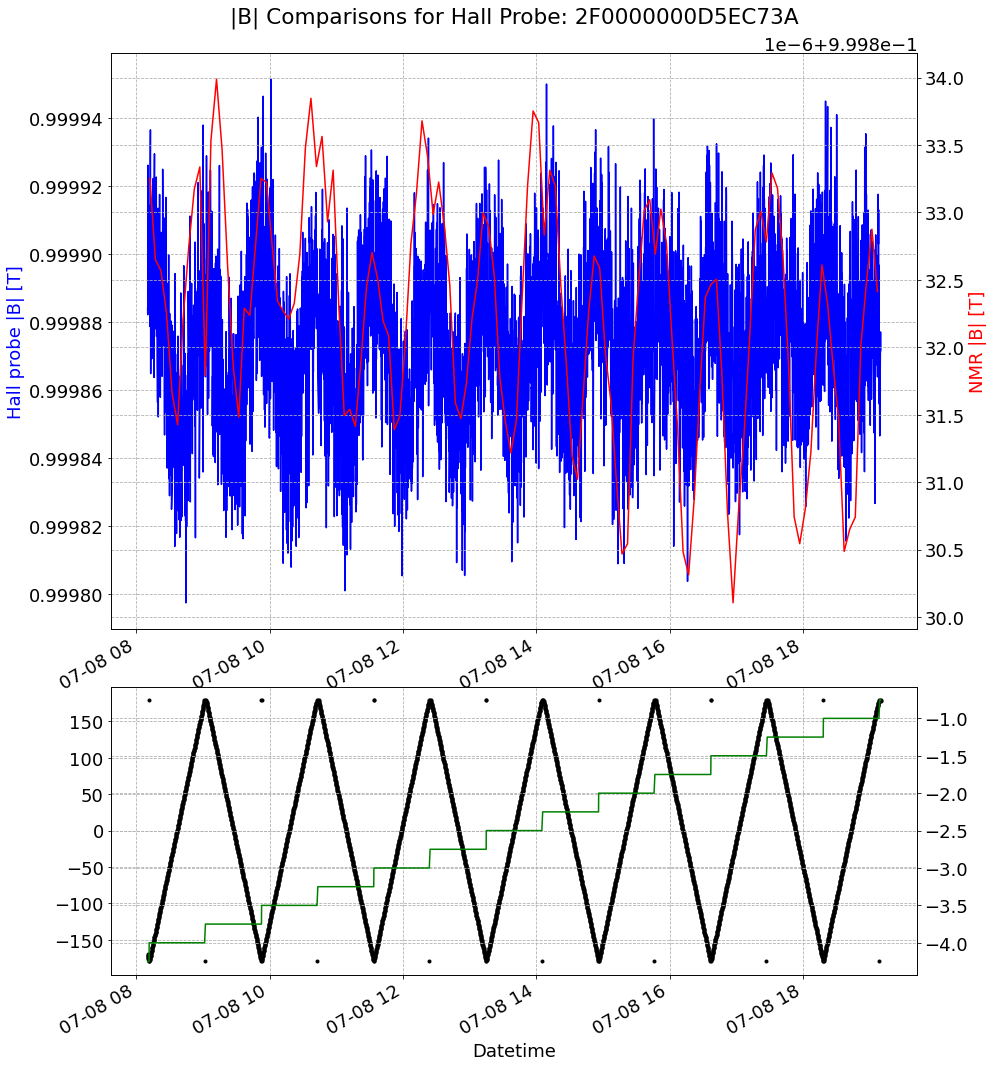

In [82]:
#t0_ = '07-07-22 12:00' # start
# tf_ = '07-10-22 00:00' # end
# t0_ = '07-08-22 16:38'
# tf_ = '07-09-22 03:45'

t0_ = '07-08-22 08:10' # central
tf_ = '07-08-22 19:10' # central
df_ = df.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()
df_t_ = df_t.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()

fig = plt.figure(figsize=(14, 16))
##ax = plt.subplot(211)
ax = plt.axes([0.1, 0.4, 0.8, 0.5])
#ax2 = plt.subplot(212, sharex=ax)
ax2 = ax.twinx()
ax3 = plt.axes([0.1, 0.1, 0.8, 0.25])
##ax3 = plt.subplot(212, sharex=ax)
ax4 = ax3.twinx()
df_[f'{probe}_Cal_Bmag'].plot(ax=ax, color='blue')
# df_[f'{probe}_Raw_Bmag'].plot(ax=ax, color='blue')
df_t_['NMR [T]'].plot(ax=ax2, color='red')
df_['SmarAct_Meas_Angle_2_Centered'].plot(ax=ax3, color='black', linestyle='None', marker='.')
df_['SmarAct_Meas_Angle_1_Centered'].plot(ax=ax4, color='green')
ax.set_ylabel(f'Hall probe |B| [T]')
ax.yaxis.label.set_color('blue')
ax2.set_ylabel(f'NMR |B| [T]')
ax2.yaxis.label.set_color('red')
ax.set_title(f"|B| Comparisons for Hall Probe: {probe}\n")

In [76]:
-2.5 + 1.5

-1.0

In [78]:
-2.5 - 1.5

-4.0

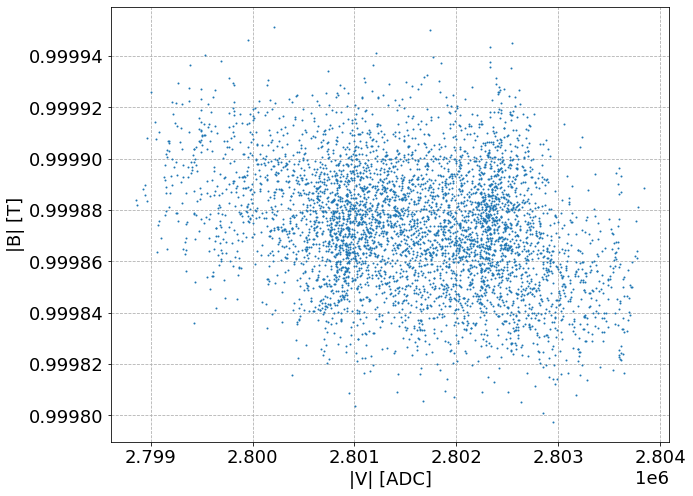

In [88]:
fig, ax = plt.subplots()\

ax.scatter(df_[f'{probe}_Raw_Bmag'], df_[f'{probe}_Cal_Bmag'], s=1)

ax.set_xlabel('|V| [ADC]')
ax.set_ylabel('|B| [T]');

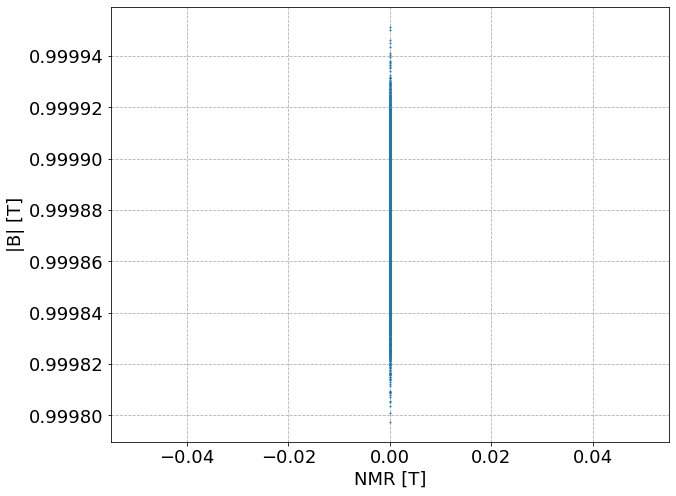

In [89]:
fig, ax = plt.subplots()\

ax.scatter(df_['NMR [T]'], df_[f'{probe}_Cal_Bmag'], s=1)

ax.set_xlabel('NMR [T]')
ax.set_ylabel('|B| [T]');

# Analysis 1: Using Cal Values

# Analysis 2: Using Raw Values